# Tracking iterative executions

One of the main primitives in our framework is `Pipeline`, which runs the same list of procedures over and over. It is essential to have a tool to notify the user on its progress; for situations where plain `tqdm` bar is just not enough we've developed `Notifier` and `Monitor` classes that provide fine-grained updates on the state of iterative flow. This notebooks shows how to:

- track utilization for a wide variety of resources (cpu, gpu, memory, etc)
- create an iteration-wise notifications for values of pipeline variables and other entities
- plot graphs (for example, loss values) on the fly

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from tqdm import tqdm_notebook, tqdm

sys.path.append('../..')
from batchflow import Notifier, Pipeline, Dataset, I, W, V, L, B
from batchflow.monitor import *

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
DEVICE = torch.device('cuda:0')
torch.ones((1, 1, 1), device=DEVICE)

BAR = 't' # can be changed to 'n' to use Jupyter Notebook progress bar everywhere

## Notifier

In the simplest case we use `Notifier` as a drop-in replacement for `tqdm` progress bar, and the behaviour remains the same. Positional argument `bar` tells which progress bar implementation to use:

- `t` stands for plain text `tqdm`
- `n` allows to make use of modern `tqdm_notebook` graphics
- `a` automatically changes from text-based to GUI, depending on the environment it is being used

In [3]:
for item in Notifier(BAR)(range(5)):
    print(item)

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 23537.06it/s]

0
1
2
3
4


As some of the loops are running hundreds of iterations per second, we should take special care of speed of updating: as we can see, the overhead is negligeable for both text and graphical versions of the `Notifier`:

In [4]:
%time for item in Notifier('t')(range(100000)): pass
%time for item in tqdm(range(100000)): pass

100%|██████████| 100000/100000 [00:00<00:00, 3081350.88it/s]

CPU times: user 191 ms, sys: 30.6 ms, total: 222 ms
Wall time: 221 ms
CPU times: user 33.9 ms, sys: 0 ns, total: 33.9 ms
Wall time: 33.6 ms


In [5]:
%time for item in Notifier('n')(range(100000)): pass
%time for item in tqdm_notebook(range(100000)): pass



CPU times: user 340 ms, sys: 26.9 ms, total: 367 ms
Wall time: 370 ms



CPU times: user 63.6 ms, sys: 591 µs, total: 64.2 ms
Wall time: 66.6 ms


## Monitors

We will return to `Notifier` and its other arguments in just a second; for now, let's look at other feature: `Monitor`s. As we intent to use our pipelines to work with enormous neural networks on gigantic datasets, we must finely control all of our resources: CPU, RAM, GPU load, etc. `Monitor`s provide us tools to visualize resource utilization over a period of time: mere addition of a special context manager allows us to look into CPU usage in details:

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]


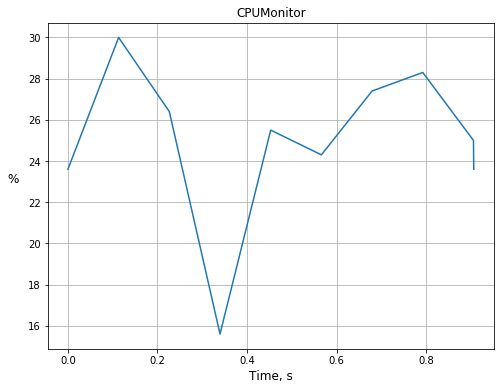

In [6]:
with CPUMonitor(frequency=0.1) as cpu_monitor:
    for _ in Notifier(BAR)(range(10)):
        _ = np.random.random((1000, 10000))
        
cpu_monitor.visualize()

Under the hood `Monitor` creates a separate process, that checks the state of a resource every `frequency` seconds and can fetch collected data on demand.

There are a number of resources that can be tracked:
- CPU utilization (`cpu`)
- RAM used by the current process (`uss`)
- total RAM used on the machine (`memory`)
- GPU utilization (`gpu`)
- GPU memory used (`gpu_memory`)

For convenience we also provide context manager to track multiple entities at once:

100%|███████████████████████████████████████████| 42/42 [00:09<00:00,  4.46it/s]


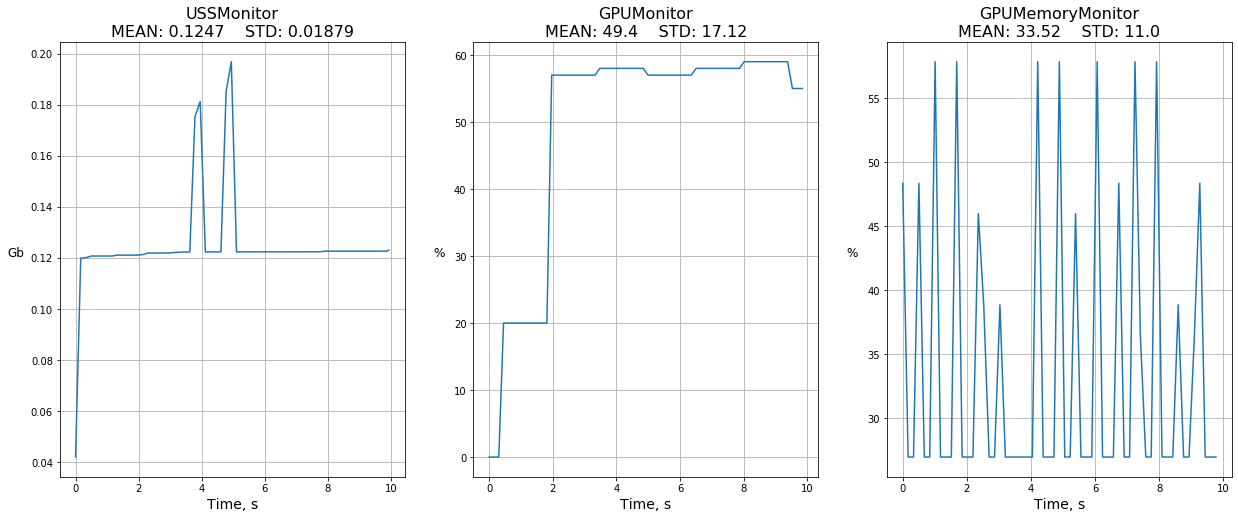

In [7]:
with Monitor(['uss', 'gpu', 'gpu_memory'], frequency=0.1) as multi_monitor:
    for _ in Notifier(BAR)(range(42)):
        cpu_data = np.random.random((1000, 10000))

        gpu_data = torch.ones((256, 512, 2096), device=DEVICE)
        gpu_op = torch.mvlgamma(torch.erfinv(gpu_data), 1)         # intense operation
        torch.cuda.empty_cache()
        
multi_monitor.visualize()

This feature is immensely helpful during both research and deploy stages, so we included it in the `Notifier` itself: it has never been so easy to always keep track of all the resources!

Note that monitors connected to an instance of `Notifier` provide information on the resource usage not only every `frequency` seconds, but also at the end of each iteration.

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.65it/s]


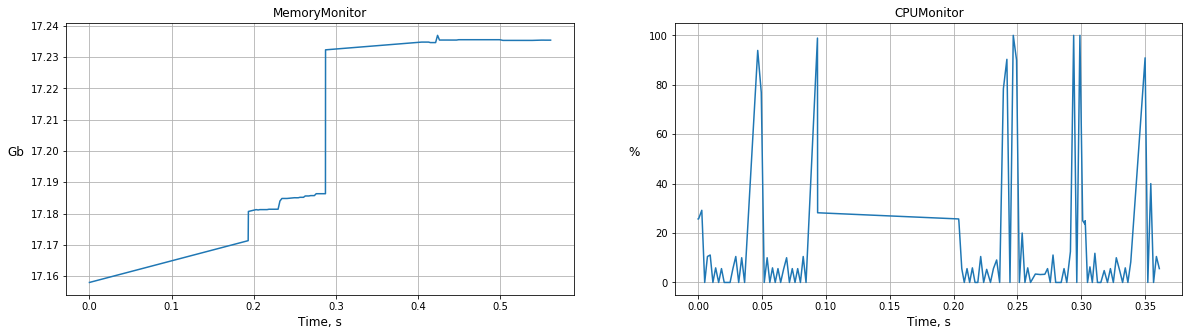

In [8]:
notifier = Notifier(BAR, monitors=['memory', 'cpu'])

for _ in notifier(range(100)):
    _ = np.random.random((1000, 100))

notifier.visualize()

## Pipeline

As was already mentioned, one of the prime purposes of our notification system is to be used in tandem with `Pipeline`. We create a rather simple one with following variables:

- list `loss_history` that is updated at each iteration with a new value
- 2D array `image` that is randomly generated at each iteration

In [9]:
pipeline = (
    Pipeline()
    .init_variable('loss_history', [])
    .init_variable('image')

    .update(V('loss_history', mode='a'), 100 * 2 ** (-I()))
    .update(V('image'), L(np.random.random)((30, 30)))
) << Dataset(10)

## Vanilla pipeline
The easiest way to track progress is to supply `notifier` argument to the `run` method. It works with:

- an instance of `Notifier`
- string (`t`, `n`, `a`) would be used as positional argument for `Notifier` creation in the bowels of `Pipeline`
- dictionary with parameters of `Notifier` initialization

In [10]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=BAR)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 5553.16it/s]


## Track pipeline variables

We can use notifier to track values of pipeline variables at each iteration: conveniently, we use the same `monitor` argument:

loss_history=0.0976562: 100%|███████████████████████████| 10/10 [00:00<00:00, 1185.77it/s]


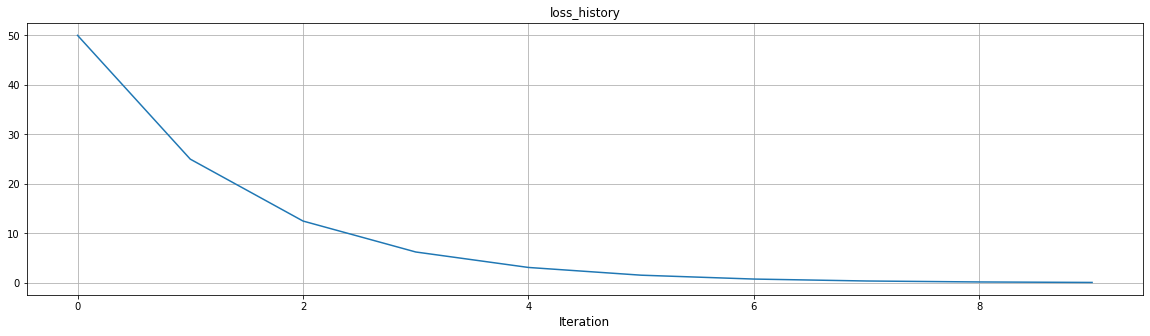

In [11]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=Notifier(BAR, monitors='loss_history'))

pipeline.notifier.visualize()

Obviously, we can use the same resource monitors, as before, by passing additional items to `monitors`. There is also `file` argument, that allows us to log the progress to an external storage:

loss_history=8.88178e-14: 100%|████████████████████████████████████| 50/50 [00:00<00:00, 580.29it/s]


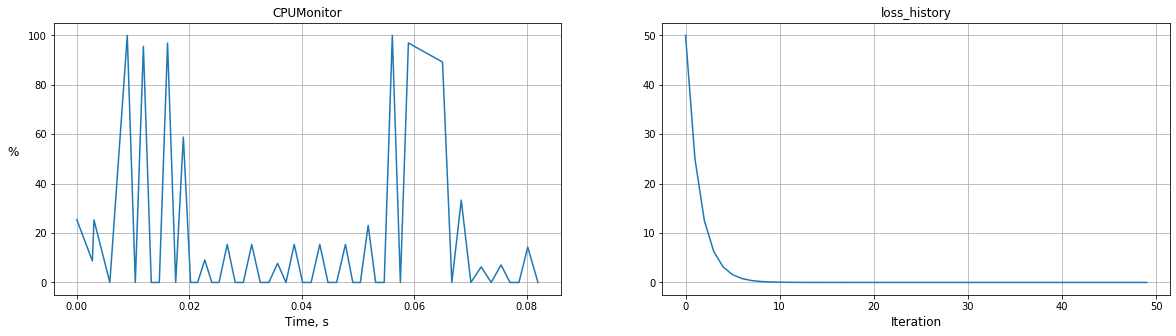

In [12]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=50, notifier=Notifier(BAR, monitors=['cpu', 'loss_history'], file='notifications.txt'))

pipeline.notifier.visualize()

In [13]:
!head notifications.txt -n 13

2020-10-30  11:58:28     Iteration     0;    loss_history=50.0  
2020-10-30  11:58:28     Iteration     1;    loss_history=25.0  
2020-10-30  11:58:28     Iteration     2;    loss_history=12.5  
2020-10-30  11:58:28     Iteration     3;    loss_history=6.25  
2020-10-30  11:58:28     Iteration     4;    loss_history=3.125 
2020-10-30  11:58:28     Iteration     5;    loss_history=1.5625
2020-10-30  11:58:28     Iteration     6;    loss_history=0.78125
2020-10-30  11:58:28     Iteration     7;    loss_history=0.390625
2020-10-30  11:58:28     Iteration     8;    loss_history=0.195312
2020-10-30  11:58:28     Iteration     9;    loss_history=0.0976562
2020-10-30  11:58:28     Iteration    10;    loss_history=0.0488281
2020-10-30  11:58:28     Iteration    11;    loss_history=0.0244141
2020-10-30  11:58:28     Iteration    12;    loss_history=0.012207


## Live plots

One of the distinct features of `Notifier` is its ability of plotting data on the fly: to do so, we must supply `graphs` argument. Its semantics are exactly the same as those of `monitors` parameter.

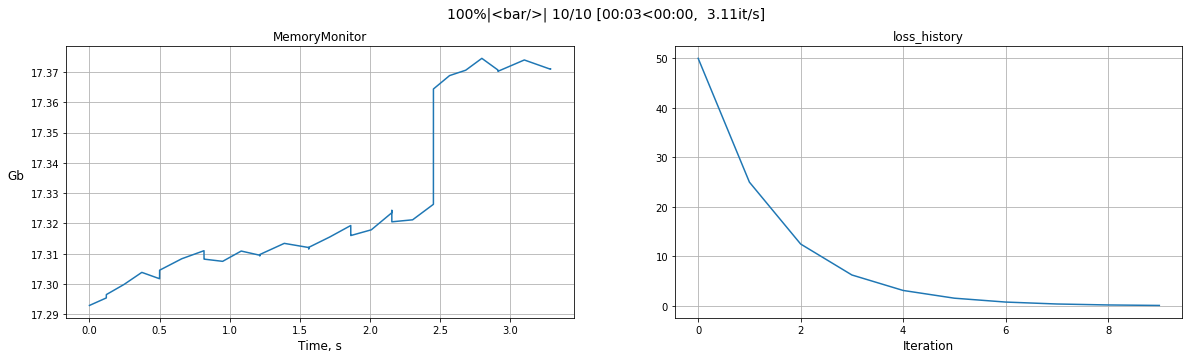

In [14]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=Notifier('n', graphs=['memory', 'loss_history']))

It can work with images also. As the rendering of plots might take some time, we want to do so once every 10 iterations and achieve so by using `frequency` parameter:

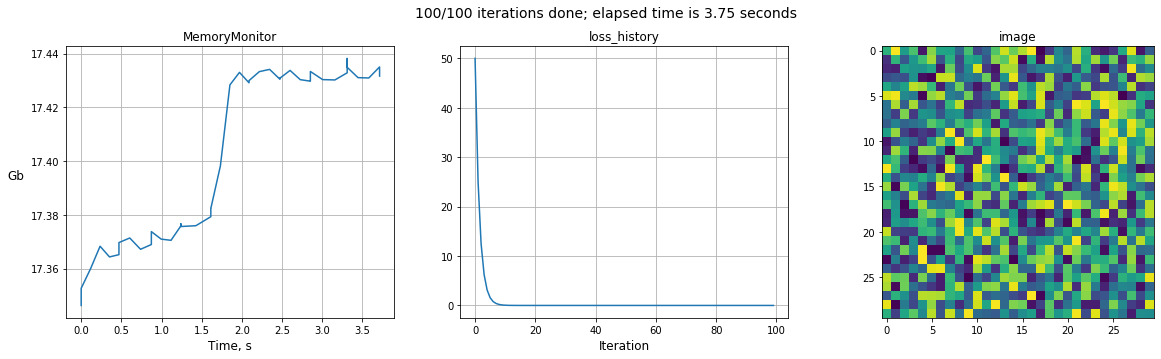

In [15]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100, notifier=Notifier(None, graphs=['memory', 'loss_history', 'image'], frequency=10))

## Advanced usage of Notifier

Different people prefer different types of notifications: for some modest `print` is enough, some build complex systems to bring notifications to their mobile devices. Our `Notifier` provides you fine control on how the data is shown so you can tune it for yourself.

Previously, we passed strings as `monitor`/`graphs` parameters to identify, which exactly pipeline variable or resource should be tracked. Under the hood, each of them is parsed to a dictionary with parameters:

- `source` determines the data generator
- `name` used for plot titles and near bar text descriptions
- `plot_function` can be called for custom plotting mechanism

We can leverage those parameters make all the plots to our liking:

In [16]:
def custom_plotter(ax=None, container=None, **kwargs):
    """ Zero-out center area of the image, change plot parameters. """
    container['data'][10:20, 10:20] = 0
    
    ax.imshow(container['data'])
    ax.set_title(container['name'], fontsize=18)
    
    ax.set_xlabel('axis one', fontsize=18)
    ax.set_ylabel('axis two', fontsize=18)

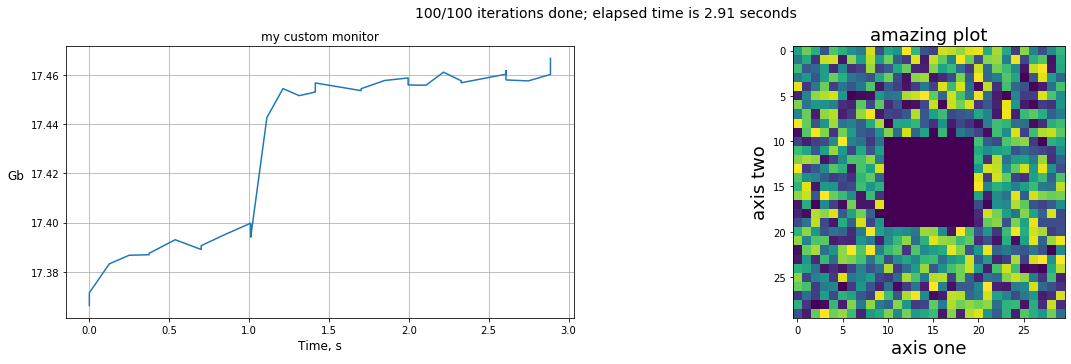

In [17]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100,
                 notifier=Notifier(None,
                                   graphs=[{'source': 'memory',
                                            'name': 'my custom monitor'},
                                           {'source': 'image',
                                            'name': 'amazing plot',
                                            'plot_function': custom_plotter}],
                                   frequency=10)
)